# Imports

In [1]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Constant utils

In [2]:
"""
Directions that the robot can face.
"""
ORIENTATION = Enum("ORIENTATION", "UP LEFT DOWN RIGHT", start=0)
"""
Steps length in each direction.
"""
TAKE_A_STEP = {
    ORIENTATION.UP: np.array([-1, 0]),
    ORIENTATION.DOWN: np.array([1, 0]),
    ORIENTATION.RIGHT: np.array([0, 1]),
    ORIENTATION.LEFT: np.array([0, -1]),
}
"""
Actions that the robot can take.
"""
ACTIONS = Enum("ACTIONS", "FORWARD BACKWARD TURN_LEFT TURN_RIGHT")
"""
Forward and backward actions steps.
"""
MOVE = {"FORWARD": 1, "BACKWARD": -1}
"""
Symbol of the robot in the corridor.
"""
ROBOT_SYMBOL = "X"
"""
Symbol of the goal of the robot in the corridor.
"""
GOAL_SYMBOL = "G"
"""
Symbol of the wall in the corridor.
"""
WALL_SYMBOL = "#"
"""
Symbol of the empty space in the corridor.
"""
EMPTY_SYMBOL = " "

"""
Dictionary that maps symbols to values.
"""
SYMBOLS_TO_VALUES = {
    EMPTY_SYMBOL: 0,
    WALL_SYMBOL: -1,
    GOAL_SYMBOL: 1,
    ROBOT_SYMBOL: 2,
}


def get_value_from_symbol(symbol):
    """
    Util function that maps a symbol to a value.
    :param symbol: symbol to map
    :return: value mapped
    """
    return SYMBOLS_TO_VALUES[symbol]

# Environment class

In [3]:
class Corridor(object):
    """
    Class that represents the corridor environment.
    """

    def __init__(self, length=10, width=5):
        """
        Constructor of the class.
        :param length: length of the corridor
        :param width: width of the corridor
        """
        self.length = length + 3
        self.width = width + 2
        # initialize the corridor
        self.corridor = np.empty((self.width, self.length), dtype=str)
        self.corridor[:] = EMPTY_SYMBOL
        # initial state of the agent: a state is defined by (y, x, orientation)
        self.agent_pos = (3, 1)
        self.agent_orientation = ORIENTATION.RIGHT
        self.corridor[self.agent_pos[0], self.agent_pos[1]] = ROBOT_SYMBOL
        # define walls
        self.corridor[:, 0] = WALL_SYMBOL
        self.corridor[0, :] = WALL_SYMBOL
        self.corridor[self.width - 1, :] = WALL_SYMBOL
        # define the goal
        self.corridor[1 : self.width - 1, self.length - 1] = GOAL_SYMBOL
        # data structure that contains the allowed actions for each state
        self.allowed_actions = {}
        self.init_allowed_actions()

    def is_allowed_action(self, state, action):
        """
        Check if an action is allowed in a given state.
        :param state: state to check
        :param action: action to check
        :return: True if the action is allowed, False otherwise
        """
        if action == ACTIONS.TURN_LEFT or action == ACTIONS.TURN_RIGHT:
            return True

        y, x, orientation = state
        y += TAKE_A_STEP[orientation][0] * MOVE[action.name]
        x += TAKE_A_STEP[orientation][1] * MOVE[action.name]

        if y < 0 or y > (self.width - 1) or x < 0 or x > (self.length - 1):
            return False

        if self.corridor[y, x] == WALL_SYMBOL:
            return False
        else:
            return True

    def init_allowed_actions(self):
        """
        Initialize the data structure that contains the allowed actions for each state.
        """
        allowed_actions = {}
        for y, row in enumerate(self.corridor):
            for x, cell in enumerate(row):
                if cell != WALL_SYMBOL:
                    for orientation in ORIENTATION:
                        allowed_actions[(y, x, orientation)] = []
                        for action in ACTIONS:
                            if self.is_allowed_action(((y, x, orientation)), action):
                                allowed_actions[(y, x, orientation)].append(action)

        self.allowed_actions = allowed_actions

    def update(self, action):
        """
        Update the environment given an action.
        :param action: action to take
        """
        if action in self.allowed_actions[self.get_state()]:
            if action == ACTIONS.TURN_LEFT:
                self.agent_orientation = ORIENTATION(
                    ((self.agent_orientation.value + 1) % 4)
                )
            elif action == ACTIONS.TURN_RIGHT:
                self.agent_orientation = ORIENTATION(
                    ((self.agent_orientation.value - 1) % 4)
                )
            else:
                if self.agent_pos[1] == self.length - 1:
                    replace = GOAL_SYMBOL
                else:
                    replace = EMPTY_SYMBOL
                self.corridor[self.agent_pos[0], self.agent_pos[1]] = replace
                self.agent_pos += (
                    TAKE_A_STEP[self.agent_orientation] * MOVE[action.name]
                )
                self.corridor[self.agent_pos[0], self.agent_pos[1]] = ROBOT_SYMBOL

    def give_reward(self):
        """
        Give the reward to the agent.
        :return: reward
        """
        if self.agent_pos[1] == self.length - 1:
            return 100
        else:
            # return (self.agent_pos[1] - self.length) / self.length
            return -1

    def is_terminal(self):
        """
        Check if the agent is in a terminal state.
        :return: True if the agent is in a terminal state, False otherwise
        """
        return self.agent_pos[1] == self.length - 1

    def plot_corridor(self):
        """
        Plot the corridor using matplotlib.
        """
        plt.figure(figsize=(30, 30))
        res = np.vectorize(SYMBOLS_TO_VALUES.get)(self.corridor)
        plt.imshow(res, cmap=plt.cm.gray, interpolation="nearest")
        plt.xticks([])
        plt.yticks([])

    def get_state(self):
        """
        Get the current state of the agent.
        The current state is defined as a tuple containing (y, x, orientation).
        :return: current state of the agent
        """
        return (self.agent_pos[0], self.agent_pos[1], self.agent_orientation)

    def get_state_and_reward(self):
        """
        Get the current state of the agent and the reward.
        :return: a tuple containing the current state of the agent and the reward
        """
        return (self.get_state(), self.give_reward())

    def get_allowed_actions(self, state):
        """
        Get the allowed actions for a given state.
        :param state: state to check
        :return: allowed actions for the given state
        """
        return self.allowed_actions[state]

    def reset_env(self):
        """
        Resets the environment.
        """
        self.corridor[:] = EMPTY_SYMBOL
        # initial state of the agent: a state is defined by (y, x, orientation)
        self.agent_pos = (3, 1)
        self.agent_orientation = ORIENTATION.RIGHT
        self.corridor[self.agent_pos[0], self.agent_pos[1]] = ROBOT_SYMBOL
        # define walls
        self.corridor[:, 0] = WALL_SYMBOL
        self.corridor[0, :] = WALL_SYMBOL
        self.corridor[self.width - 1, :] = WALL_SYMBOL
        # define the goal
        self.corridor[1 : self.width - 1, self.length - 1] = GOAL_SYMBOL

In [4]:
class Agent(object):
    """
    Class that represents the agent.
    """

    def __init__(self, env, gamma=0.5, alpha=0.9, epsilon=0.5):
        """
        Constructor of the class.
        :param env: environment
        :param gamma: discount factor
        :param alpha: learning rate
        :param epsilon: exploration rate
        """
        # environment
        self.env = env
        # discount factor
        self.gamma = gamma
        # exploration rate -> 0: greedy, 1: random
        self.epsilon = epsilon
        # learning rate
        self.alpha = alpha
        # value function
        self.V = {}
        self.init_V()
        # history
        self.trajectory = []
        self.total_reward = 0
        self.steps = 0

    def init_V(self):
        """
        Initialize the value function.
        """
        for y in range(1, self.env.corridor.shape[0] - 1):
            for x in range(1, self.env.corridor.shape[1]):
                for orientation in ORIENTATION:
                    self.V[(y, x, orientation)] = np.random.uniform(0.01, 1)

    def best_action(self, state, allowed_actions):
        """
        Get the best action for a given state.
        :param state: state to check
        :param allowed_actions: allowed actions for the given state
        :return: best action for the given state
        """
        best_action = None
        best_value = -np.inf
        # compute the value of each action and return the best one
        for action in allowed_actions:
            y, x, orientation = state
            if action == ACTIONS.TURN_LEFT:
                orientation = ORIENTATION(((orientation.value + 1) % 4))
            elif action == ACTIONS.TURN_RIGHT:
                orientation = ORIENTATION(((orientation.value - 1) % 4))
            else:
                y += TAKE_A_STEP[orientation][0] * MOVE[action.name]
                x += TAKE_A_STEP[orientation][1] * MOVE[action.name]
            value = self.V[(y, x, orientation)]
            if value > best_value:
                best_value = value
                best_action = action
        return best_action

    def update_trajectory(self, state, reward):
        """
        Update the trajectory of the agent.
        :param state: current state
        :param reward: reward
        """
        self.steps += 1
        self.total_reward += reward
        self.trajectory.append((state, reward))

    def choose_action(self, state):
        """
        Choose an action given the state, using the epsilon-greedy policy.
        :param state: current state
        :return: action chosen
        """
        allowed_actions = self.env.get_allowed_actions(state)
        # epsilon-greedy: 0: greedy, 1: random
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(allowed_actions)
        else:
            return self.best_action(state, allowed_actions)

    def monte_carlo_update(self):
        """
        Update the value function using the Monte Carlo method.
        """
        g = 0
        for state, reward in reversed(self.trajectory):
            g = self.gamma * g + reward
            self.V[state] += self.alpha * (g - self.V[state])
        # reset the history
        self.trajectory = []
        self.total_reward = 0
        self.steps = 0
        self.env.reset_env()
        # as epochs go by, reduce the exploration rate -> more greedy
        self.epsilon = self.epsilon * 0.99

### Testing the environment

1 3 ORIENTATION.RIGHT
[<ACTIONS.FORWARD: 1>, <ACTIONS.TURN_LEFT: 3>, <ACTIONS.TURN_RIGHT: 4>]


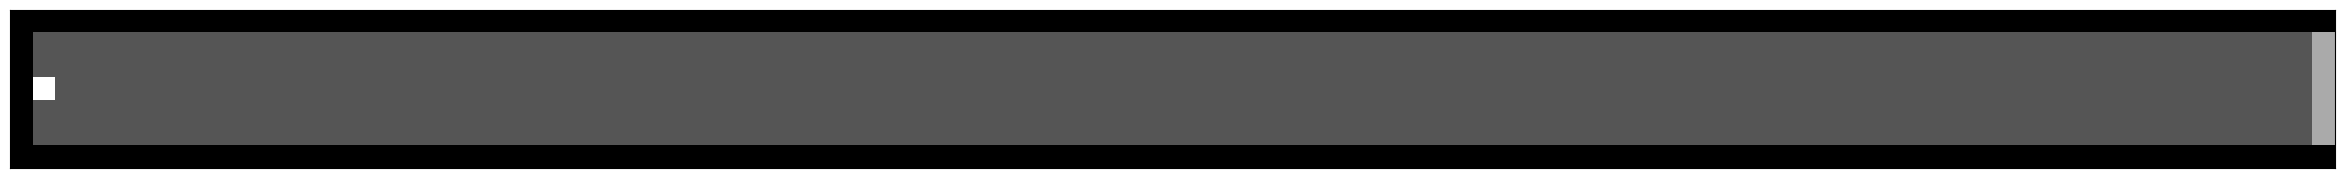

In [5]:
corridor = Corridor(length=100)
state = corridor.get_state()
print(state[1], state[0], state[2])
print(corridor.get_allowed_actions(state))
corridor.plot_corridor()

#### Testing some actions

1 3 ORIENTATION.RIGHT
[<ACTIONS.FORWARD: 1>, <ACTIONS.TURN_LEFT: 3>, <ACTIONS.TURN_RIGHT: 4>]


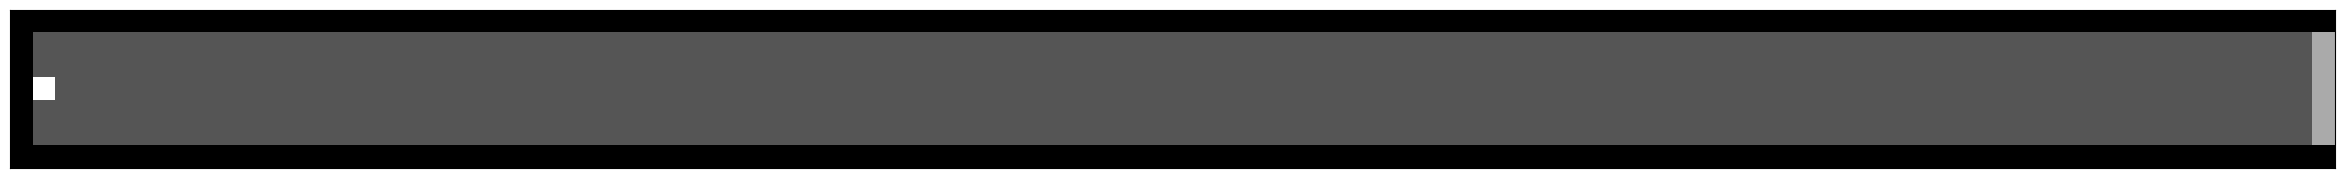

In [6]:
if ACTIONS.BACKWARD in corridor.get_allowed_actions(state):
    corridor.update(ACTIONS.BACKWARD)
state = corridor.get_state()
print(state[1], state[0], state[2])
print(corridor.get_allowed_actions(state))
corridor.plot_corridor()

# Training the robot

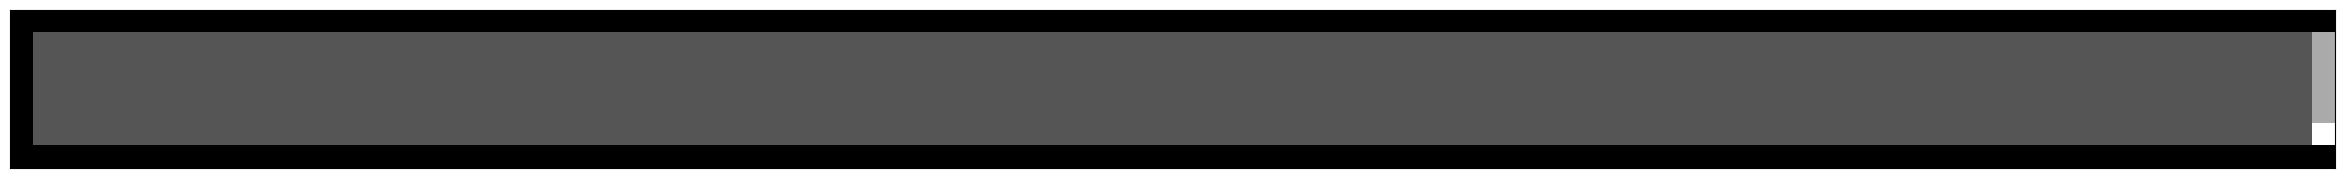

Episode: 900
Last number of steps: 107
Last total reward: -6
Epsilon: 1.179438058956442e-05


In [17]:
corridor = Corridor(length=100)
robot = Agent(corridor, epsilon=0.1)

steps_history = []
reward_history = []

n_epochs = 1000
max_steps = 500
for i in range(n_epochs):
    # run an episode
    while not corridor.is_terminal():
        # get the current state
        state = corridor.get_state()
        # choose an action based on the current state
        action = robot.choose_action(state)
        # apply the action of the agent on the environment
        corridor.update(action)
        # get the new state and the reward of that action
        state, reward = corridor.get_state_and_reward()
        # keep track of the trajectory of the agent
        robot.update_trajectory(state, reward)
        # stop the episode if the agent is stuck
        if robot.steps > max_steps:
            break

    reward_history.append(robot.total_reward)
    steps_history.append(robot.steps)

    if i % (n_epochs // 10) == 0:
        time.sleep(0.3)
        clear_output(wait=True)
        corridor.plot_corridor()
        plt.show()
        print(
            f"Episode: {i}\nLast number of steps: {steps_history[-1]}\nLast total reward: {reward_history[-1]}\nEpsilon: {robot.epsilon}"
        )

    # episode is finished, update the V function
    robot.monte_carlo_update()

## Plotting the results of the training

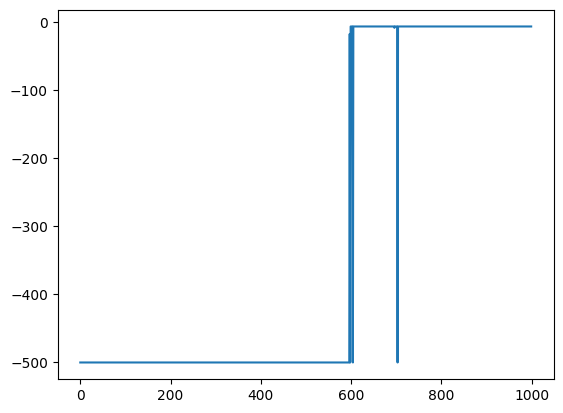

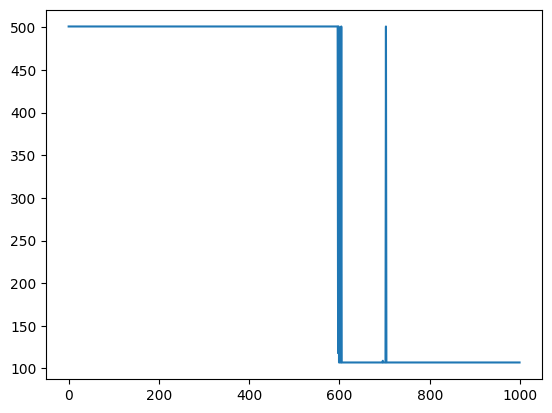

In [18]:
plt.plot(reward_history)
plt.show()
plt.plot(steps_history)
plt.show()

# Creating a gif of the trained robot trying to reach the end of the corridor

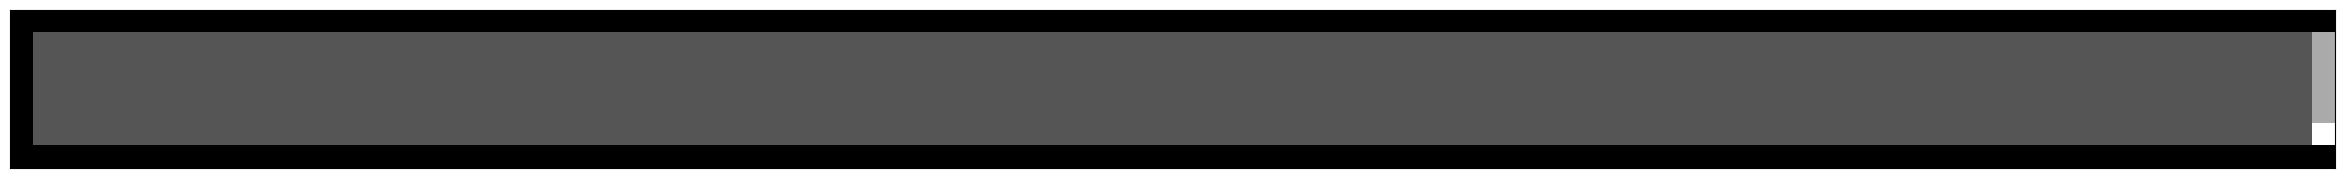

In [20]:
corridor.reset_env()
i = 0
while not corridor.is_terminal():
    time.sleep(0.1)
    clear_output(wait=True)
    corridor.plot_corridor()
    plt.savefig(
        f"images/working-robot/working-{'0'*(3-len(str(i))) + str(i)}.jpg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    plt.show()
    state = corridor.get_state()
    action = robot.best_action(state, corridor.get_allowed_actions(state))
    corridor.update(action)
    i += 1

clear_output(wait=True)
corridor.plot_corridor()
plt.savefig(
    f"images/working-robot/working-{'0'*(3-len(str(i))) + str(i)}.jpg",
    bbox_inches="tight",
    pad_inches=0,
    dpi=300,
)
plt.show()
state = corridor.get_state()
action = robot.best_action(state, corridor.get_allowed_actions(state))
corridor.update(action)
i += 1

In [21]:
import glob
from PIL import Image

images = sorted(glob.glob(r"images/working-robot/*.jpg"))
print(images[0])
images_array = []
for image in images:
    images_array.append(Image.open(image))

print(len(images_array))

images/working-robot/working-000.jpg
108


(-0.5, 6974.5, 473.5, -0.5)

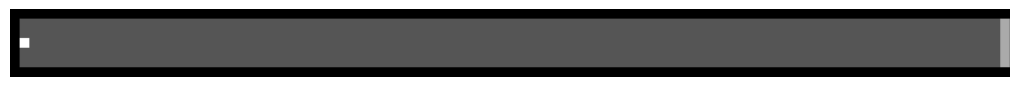

In [22]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
fig.set_size_inches(10, 3)
im = ax.imshow(images_array[0], animated=True)
plt.axis("off")

In [23]:
def update(i):
    im.set_array(images_array[i])
    return (im,)

In [24]:
import matplotlib.animation as animation

animation_fig = animation.FuncAnimation(
    fig, update, frames=len(images_array), interval=100, blit=True, repeat_delay=100
)

In [25]:
animation_fig.save
animation_fig.save("images/working-robot.gif", writer="pillow")